This file is to compare the noise (gaussian vs t3)


### import and define

In [1]:
import sys
sys.path.append("../../mypkg")
from constants import RES_ROOT, FIG_ROOT, DAT_ROOT

#### Other pkgs

In [2]:
from tqdm import trange, tqdm

import torch
import umap
import torch.nn as nn 
import torch.nn.functional as F 
from sbi import utils as sutils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from torch.distributions.multivariate_normal import MultivariateNormal

import numpy as np
import xarray as xr
from easydict import EasyDict as edict
from collections import defaultdict as ddict
from pathlib import Path
import pickle
import scipy

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import json
from functools import partial

import warnings
warnings.filterwarnings("ignore")

plt.style.use(FIG_ROOT/"base.mplstyle")

#### My own pkgs

In [3]:
import importlib

from utils.misc import mag2db, meg_psd2spatialfeature, save_pkl_dict2folder, load_pkl_folder2dict, geodesic_dist
from utils.standardize import stdz_psd, stdz_vec, minmax_vec, psd_2tr
from utils.brain_plot import U2BrainVec, reorderU 
from utils.reparam import theta_raw_2out, normcdf_np, normcdf_torch, logistic_np, logistic_torch
from utils.stable import paras_table_check
from sgm.sgm import SGM
from spectrome import Brain, path, functions
from features.psm import obt_psm_fs, obt_psm_raw
from constants import RES_ROOT, FIG_ROOT, DAT_ROOT
from models.embedding_nets import SummaryNet
from sgm.data_gen import simulator_data

### Load real data PSD and brain

#### PSD and connectome

In [4]:
# Load data
ind_psd_xr = xr.open_dataarray(DAT_ROOT/'individual_psd_reordered_matlab.nc')
ind_psd = ind_psd_xr.values
FREQS = ind_psd_xr["frequencies"].values
ind_conn_xr = xr.open_dataarray(DAT_ROOT/'individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values;

#### Set up Parameters

In [5]:
# some constant parameters for this file
paras = edict()
#bnds = ((5.0,30.0), (5.0,200.0), (0.1,1.0), (5, 20), (0.001,0.7), (0.001,2.0), (5.0,30.0))
#Bounds for taue, taui, alpha, speed, gei, gii, tauC
# (0.001,0.7), (0.001,2.0) when considering stable checking.
# (0.001,0.5), (0.001,1.5) as safe (narrower) bounds

# taue, taui, tauC, speed, alpha, gii, gei
paras.par_low = np.asarray([0.005,0.005,0.005,5, 0.1,0.001,0.001])
paras.par_high = np.asarray([0.03, 0.20, 0.03,20,  1,    2,  0.7])
paras.prior_bds = np.array([paras.par_low, paras.par_high]).T
paras.names = ["Taue", "Taui", "TauC", "Speed", "alpha", "gii", "gei"]

paras.num_prior_sps = int(1e5)
paras.noise_sd = 1.6
paras.den_est = "nsf"
paras.is_embed = False

paras.prior_sd = 10

In [6]:
# paras  for this file
_paras = edict()
_folder_path = f"./new_bds[0-9]*_reparam{paras.num_prior_sps:.0f}" +\
                   f"_sd{paras.noise_sd*100:.0f}" +\
                   f"_denest{paras.den_est}" +\
                   f"_embed{paras.is_embed}_t3"
fils = list(RES_ROOT.glob(_folder_path))
_paras.fils_t3 = sorted(fils, key=lambda x: int(x.stem.split("bds")[1].split("_")[0]))

_folder_path = f"./new_bds[0-9]*_reparam{paras.num_prior_sps:.0f}" +\
                   f"_sd{paras.noise_sd*100:.0f}" +\
                   f"_denest{paras.den_est}" +\
                   f"_embed{paras.is_embed}"
fils = list(RES_ROOT.glob(_folder_path))
_paras.fils_norm = sorted(fils, key=lambda x: int(x.stem.split("bds")[1].split("_")[0]))

_paras.name_order = ['taue','taui','tauG','speed','alpha','gii','gei']
_paras.name_order_latex = [r'$\tau_e$',r'$\tau_i$',r'$\tau_G$',r'$v$',r'$\alpha$',r'$g_{ii}$',r'$g_{ei}$']

# plot setting
_paras.plot_sets = edict()
_paras.plot_sets.col = ["dodgerblue", "coral"]
_paras.plot_sets.alpha = 0.8
_paras.plot_sets.marker = ["o", "h"]

_paras.metd = edict()
_paras.metd.t3 = "t(3)"
_paras.metd.norm = "Normal"

In [7]:
# obtain the brain
brain = Brain.Brain()
brain.add_connectome(DAT_ROOT)
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()
sgmmodel = SGM(brain.reducedConnectome, brain.distance_matrix, FREQS)

In [8]:
meg_psd_curve = np.median([np.mean(psd_2tr(ind_psd[:, :, ix]), axis=0) for ix in range(36)], axis=0)
#meg_psd_curve = np.mean([psd_2tr(ind_psd[:, :, ix]).mean(axis=0) for ix in range(36)], axis=0)
meg_psd_roi_sub = np.array([psd_2tr(ind_psd[:, :, ix]) for ix in range(36)])

# the estimated spatial feature from MEG
meg_sps = []
meg_sp_raws = []
for ix in trange(36):
    curC = ind_conn[:, :, ix]
    curBrain = Brain.Brain()
    curBrain.add_connectome(DAT_ROOT) # grabs distance matrix
    # re-ordering for DK atlas and normalizing the connectomes:
    curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
    curBrain.connectome = curC# re-assign connectome to individual connectome
    curBrain.bi_symmetric_c()
    curBrain.reduce_extreme_dir()
    
    curMEGSP, curMEGSPRaw = meg_psd2spatialfeature(curBrain.reducedConnectome, ind_psd[:, :, ix], FREQS)
    meg_sps.append(curMEGSP)
    meg_sp_raws.append(curMEGSPRaw.sum(axis=1))

meg_sps = np.array(meg_sps)
meg_sp_raws = np.array(meg_sp_raws);

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 52.26it/s]


### T-3 noise vs gaussian noise

In [9]:
cur_ress_t3 = [load_pkl_folder2dict(cur_fil, ["*_raw", "posterior"], verbose=False) 
            for cur_fil in tqdm(_paras.fils_t3) ]
cur_ress_norm = [load_pkl_folder2dict(cur_fil, ["*_raw", "posterior"], verbose=False) 
            for cur_fil in tqdm(_paras.fils_norm) ];

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.77it/s]


In [10]:
result = ddict(list)
for cur_res in tqdm(cur_ress_t3):
    est_psds = []
    est_FCs = []
    est_sps = []
    
    post_psd_sps = []
    post_sp_sps = []
    for post_psd in cur_res.fb_post_res:
        est_psd = np.mean(post_psd[:, :-68], axis=0)
        est_psd = est_psd.reshape(68, 40)
        est_sp = np.mean(post_psd[:, -68:], axis=0)
        
        est_psds.append(est_psd)
        est_sps.append(est_sp)
        est_FCs.append(np.corrcoef(est_psd))
    
        post_psd_sps.append(post_psd[:, :-68].reshape(-1, 68, 40))
        post_sp_sps.append(post_psd[:, -68:].reshape(-1, 68))
        
    # single corr
    sgm_psd_curve_fb = np.median(np.mean(np.array(est_psds), axis=1), axis=0)
    #sgm_psd_curve_fb = np.array(est_psds).mean(axis=1).mean(axis=0)
    corr = scipy.stats.pearsonr(stdz_vec(meg_psd_curve), stdz_vec(sgm_psd_curve_fb))[0]
    #print(f"Corr is {corr:.3f}")
    
    # Corrs for PSD and spatial features for each subject
    sgm_psd_roi_sub_fb = np.array(est_psds)
    corrs_roi_sub_fb = []
    for ix in range(meg_psd_roi_sub.shape[0]):
        cur_meg = meg_psd_roi_sub[ix]
        cur_sgm = sgm_psd_roi_sub_fb[ix]
        corrs_roi_sub_fb.append(np.mean([scipy.stats.pearsonr(cur_meg[iy], cur_sgm[iy])[0] for iy in range(68)]))
    corrs_roi_sub_fb = np.array(corrs_roi_sub_fb)
    
    sgm_sp_sub = np.array(est_sps)
    corrs_sp = []
    for ix in range(meg_sps.shape[0]):
        cur_meg = meg_sps[ix]
        cur_sgm = cur_res.raw_sp[ix]
        #cur_sgm = est_sps[ix]
        corrs_sp.append(np.dot(cur_sgm/np.linalg.norm(cur_sgm), cur_meg))
    
    # geodesic dist
    geo_dists = [geodesic_dist(np.corrcoef(meg_psd_roi_sub[iz]), est_FCs[iz]) for iz in range(36)]
    
    result["sgm_psd_curs"].append(sgm_psd_curve_fb)
    result["corr"].append(corr)
    result["corrs_sp"].append(corrs_sp)
    result["corrs_roi_sub"].append(corrs_roi_sub_fb)
    result["geo_dists"].append(geo_dists)
    result["post_psd_spss"].append(post_psd_sps)
    result["post_sp_spss"].append(post_sp_sps)
result_t3 = edict(result);

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.08it/s]


In [11]:
result = ddict(list)
for cur_res in tqdm(cur_ress_norm):
    est_psds = []
    est_FCs = []
    est_sps = []
    
    post_psd_sps = []
    post_sp_sps = []
    for post_psd in cur_res.fb_post_res:
        est_psd = np.mean(post_psd[:, :-68], axis=0)
        est_psd = est_psd.reshape(68, 40)
        est_sp = np.mean(post_psd[:, -68:], axis=0)
        
        est_psds.append(est_psd)
        est_sps.append(est_sp)
        est_FCs.append(np.corrcoef(est_psd))
    
        post_psd_sps.append(post_psd[:, :-68].reshape(-1, 68, 40))
        post_sp_sps.append(post_psd[:, -68:].reshape(-1, 68))
        
    # single corr
    sgm_psd_curve_fb = np.median(np.mean(np.array(est_psds), axis=1), axis=0)
    #sgm_psd_curve_fb = np.array(est_psds).mean(axis=1).mean(axis=0)
    corr = scipy.stats.pearsonr(stdz_vec(meg_psd_curve), stdz_vec(sgm_psd_curve_fb))[0]
    #print(f"Corr is {corr:.3f}")
    
    # Corrs for PSD and spatial features for each subject
    sgm_psd_roi_sub_fb = np.array(est_psds)
    corrs_roi_sub_fb = []
    for ix in range(meg_psd_roi_sub.shape[0]):
        cur_meg = meg_psd_roi_sub[ix]
        cur_sgm = sgm_psd_roi_sub_fb[ix]
        corrs_roi_sub_fb.append(np.mean([scipy.stats.pearsonr(cur_meg[iy], cur_sgm[iy])[0] for iy in range(68)]))
    corrs_roi_sub_fb = np.array(corrs_roi_sub_fb)
    
    sgm_sp_sub = np.array(est_sps)
    corrs_sp = []
    for ix in range(meg_sps.shape[0]):
        cur_meg = meg_sps[ix]
        cur_sgm = cur_res.raw_sp[ix]
        #cur_sgm = est_sps[ix]
        corrs_sp.append(np.dot(cur_sgm/np.linalg.norm(cur_sgm), cur_meg))
    
    # geodesic dist
    geo_dists = [geodesic_dist(np.corrcoef(meg_psd_roi_sub[iz]), est_FCs[iz]) for iz in range(36)]
    
    result["sgm_psd_curs"].append(sgm_psd_curve_fb)
    result["corr"].append(corr)
    result["corrs_sp"].append(corrs_sp)
    result["corrs_roi_sub"].append(corrs_roi_sub_fb)
    result["geo_dists"].append(geo_dists)
    result["post_psd_spss"].append(post_psd_sps)
    result["post_sp_spss"].append(post_sp_sps)
result_norm = edict(result);

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.52it/s]


#### Robust

In [13]:
# norm vs t3
corrs_sub = np.median(result_norm.corrs_roi_sub, axis=1)
print(np.round([np.min(corrs_sub), np.max(corrs_sub)], 4))
corrs_sub = np.median(result_t3.corrs_roi_sub, axis=1)
print(np.round([np.min(corrs_sub), np.max(corrs_sub)], 4))

[0.905  0.9068]
[0.9049 0.9066]


#### results on a representative rep

In [17]:
# choose the one
corrs_sub = np.median(result_norm.corrs_roi_sub, axis=1)
sel_idx_norm = np.argmin(np.abs(corrs_sub-np.mean(corrs_sub)))
corrs_sub = np.median(result_t3.corrs_roi_sub, axis=1)
sel_idx_t3 = np.argmin(np.abs(corrs_sub-np.mean(corrs_sub)));


# load the one
sel_res_t3 =  load_pkl_folder2dict(_paras.fils_t3[sel_idx_t3], ["*_raw"], verbose=False)
sel_res_norm =  load_pkl_folder2dict(_paras.fils_norm[sel_idx_norm], ["*_raw"], verbose=False);

##### Boxplot

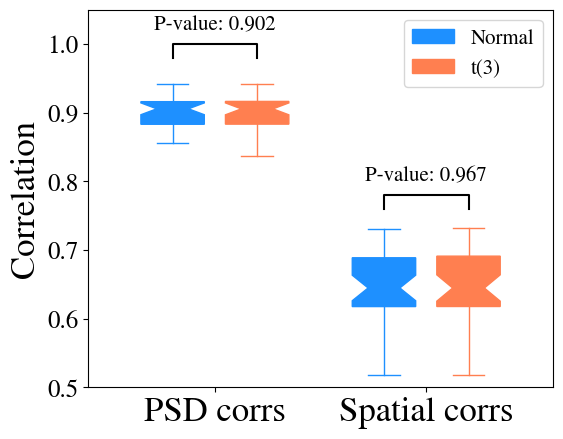

In [18]:
corr_sp_norm = result_norm.corrs_sp[sel_idx_norm];
corr_sp_t3 = result_t3.corrs_sp[sel_idx_t3];

corr_norm = result_norm.corrs_roi_sub[sel_idx_norm];
corr_t3 = result_t3.corrs_roi_sub[sel_idx_t3];

plt.figure(figsize=[6, 5], dpi=100)
box = plt.boxplot(corr_norm, positions=[0.4],
                  notch=True, showfliers=False,  patch_artist=True);
for item in ['boxes', 'whiskers',  'medians', 'caps']:
    plt.setp(box[item], color=_paras.plot_sets.col[0])
box1 = box
    
box = plt.boxplot(corr_t3, positions=[0.6],
                  notch=True, showfliers=False,  patch_artist=True);
for item in ['boxes', 'whiskers',  'medians', 'caps']:
    plt.setp(box[item], color=_paras.plot_sets.col[1])
box2 = box
pv = scipy.stats.ttest_ind(corr_norm, corr_t3).pvalue
dlt = 0.02
base_h = 0.98
plt.plot([0.4, 0.4, 0.6, 0.6], [base_h, base_h+dlt, base_h+dlt, base_h], "-", color="black")
plt.text(0.5, base_h+dlt+0.02, f"P-value: {pv:.3f}", ha="center")
    
box = plt.boxplot(corr_sp_norm, positions=[.9],
                  notch=True, showfliers=False,  patch_artist=True);
for item in ['boxes', 'whiskers',  'medians', 'caps']:
    plt.setp(box[item], color=_paras.plot_sets.col[0])
    
box = plt.boxplot(corr_sp_t3, positions=[1.1],
                  notch=True, showfliers=False,  patch_artist=True);
for item in ['boxes', 'whiskers',  'medians', 'caps']:
    plt.setp(box[item], color=_paras.plot_sets.col[1])
pv = scipy.stats.ttest_ind(corr_sp_norm, corr_sp_t3).pvalue
dlt = 0.02
base_h = 0.76
plt.plot([0.9, 0.9, 1.1, 1.1], [base_h, base_h+dlt, base_h+dlt, base_h], "-", color="black")
plt.text(1.0, base_h+dlt+0.02, f"P-value: {pv:.3f}", ha="center")

plt.xlim([0.2, 1.3])
plt.ylim([0.5, 1.05])
plt.xticks([0.5, 1], ["PSD corrs", "Spatial corrs"], fontsize=25)
plt.ylabel("Correlation", fontsize=25)
plt.legend([box1["boxes"][0], box2["boxes"][0]], [_paras.metd.norm, _paras.metd.t3], fontsize=15)
plt.savefig(FIG_ROOT/"neuroimage_r1/Corr_boxplots.jpg", dpi=1000)

##### PSD curve

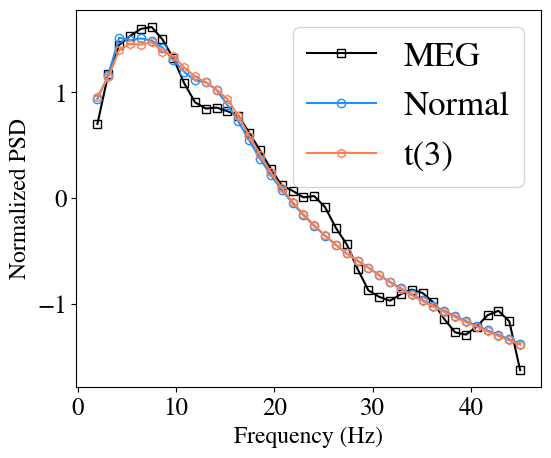

In [19]:
plt.figure(figsize=[6, 5], dpi=100)
plt.plot(FREQS, stdz_vec(meg_psd_curve), 
         linestyle = '-',marker = 's',
         fillstyle = 'none',color = 'k', 
         label = "MEG")
plt.plot(FREQS, stdz_vec(result_norm.sgm_psd_curs[sel_idx_norm]), 
         linestyle = '-', marker=_paras.plot_sets.marker[0],
         fillstyle = 'none',color = _paras.plot_sets.col[0], 
         label = _paras.metd.norm)
plt.plot(FREQS, stdz_vec(result_t3.sgm_psd_curs[sel_idx_t3]), 
         linestyle = '-',marker=_paras.plot_sets.marker[1],
         fillstyle = 'none',color = _paras.plot_sets.col[1], 
         label = _paras.metd.t3)
plt.xlabel('Frequency (Hz)', fontsize = 17)
plt.ylabel('Normalized PSD', fontsize = 17)
plt.legend()

plt.savefig(FIG_ROOT/"neuroimage_r1/PSD_compare.jpg", dpi=300)

##### KDE of sps

In [21]:
post_spss_pool_norm = np.concatenate([ix[:9000, :] for ix in sel_res_norm.post_spss])
post_spss_pool_t3 = np.concatenate([ix[:9000, :] for ix in sel_res_t3.post_spss]);

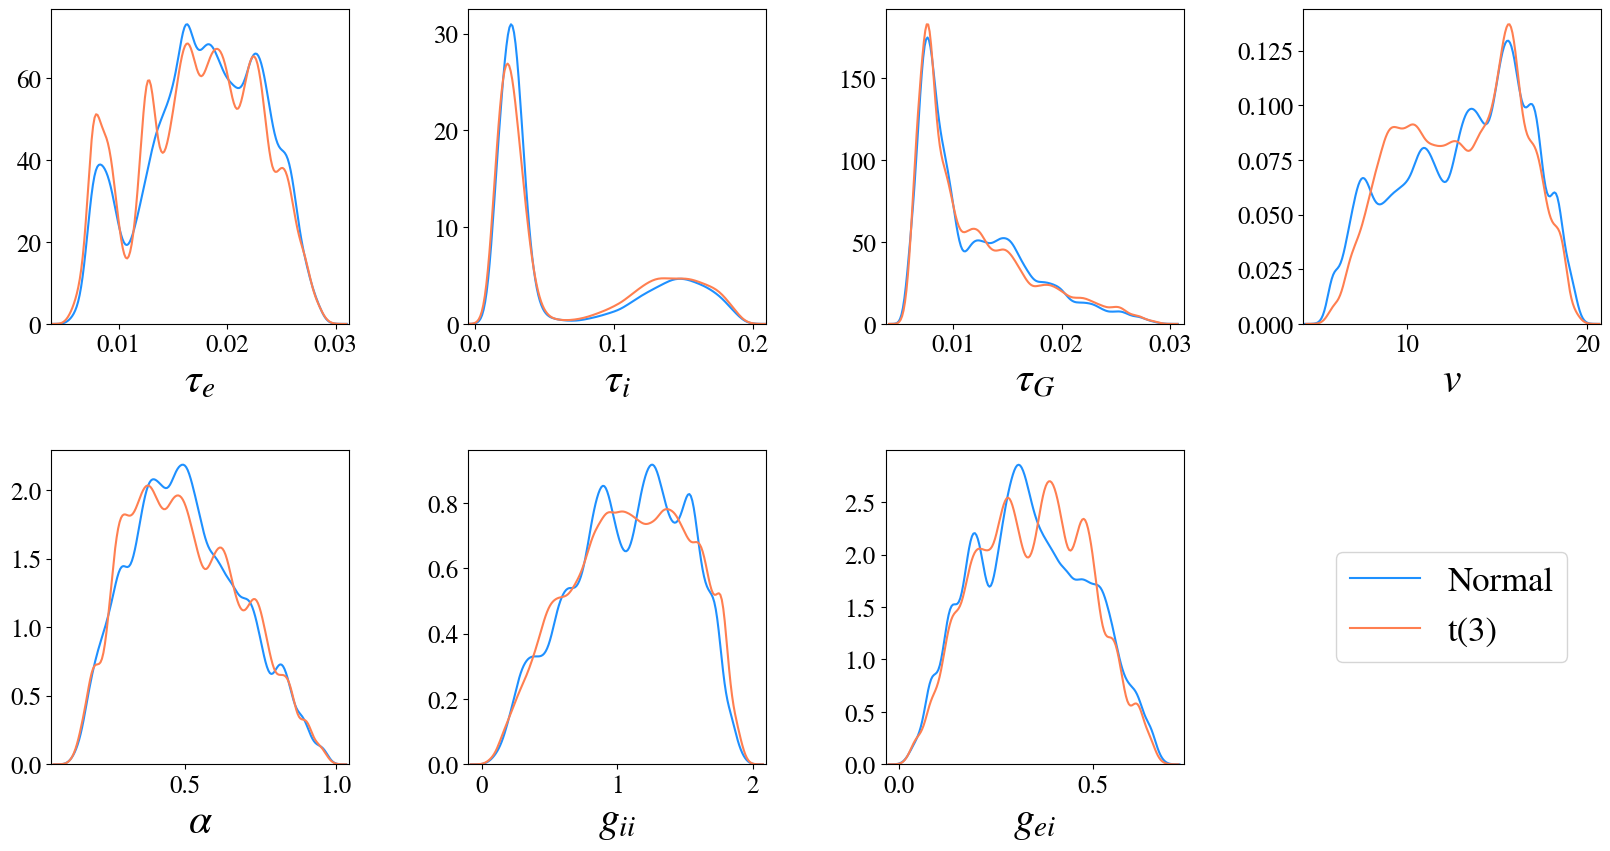

In [23]:
#plt.figure(figsize=[20, 10])
plt.figure(figsize=[20, 10], dpi=100)
for ix in range(7):
    plt.subplot(2, 4, ix+1)
    #plt.hist(post_spss_pool[:, ix], bins=20, density=True, 
    #         alpha=0.8, color=_paras.plot_sets.col[0])
    sns.kdeplot(post_spss_pool_norm[:, ix], color=_paras.plot_sets.col[0], label=_paras.metd.norm)
    sns.kdeplot(post_spss_pool_t3[:, ix], color=_paras.plot_sets.col[1], label=_paras.metd.t3)
    adj_fct = np.diff(paras.prior_bds[ix])*np.array([-0.05, 0.05])
    plt.xlim(paras.prior_bds[ix]+adj_fct)
    plt.xlabel(_paras.name_order_latex[ix], fontsize=30)
    #plt.ylim([0, 10])
    plt.ylabel("")
    
plt.subplot(2, 4, 8)
plt.axis('off')

fig = plt.gcf()
axes = fig.get_axes()
ax = axes[0]
handles, labels = [], []
for h, l in zip(*ax.get_legend_handles_labels()):
    handles.append(h)
    labels.append(l)

plt.legend(handles, labels, loc='center')
plt.savefig(FIG_ROOT/f"neuroimage_r1/histpara_all.jpg",  bbox_inches='tight', dpi=1000)

##### Partial corr

Corr of X and Y when removing the effect of other variables

In [24]:
def lr_resi(Y, X):
    """Return the residual of linear reg with Y ~ 1+X
        args: 
            Y: n 
            X: n x p
    """
    # add slope
    X = np.concatenate([np.ones(X.shape[0]).reshape(-1, 1), X], axis=1)
    beta = np.linalg.inv(X.T @ X) @ X.T @ Y
    residuals = Y - X @ beta
    return residuals

In [25]:
part_corrs_mats_norm = []
for iz in trange(36):
    cur_spss = sel_res_norm.post_spss[iz]
    part_corrs = np.zeros((7, 7))
    for ix in range(7):
        for iy in range(ix+1, 7):
            Y1 = cur_spss[:, ix]
            Y2 = cur_spss[:, iy]
            X = np.delete(cur_spss, [ix, iy], axis=1)
            
            res_Y1 = lr_resi(Y1, X)
            res_Y2 = lr_resi(Y2, X)
            part_cvs = scipy.stats.pearsonr(res_Y1, res_Y2)
            part_corrs[ix, iy] = part_cvs[0]
    part_corrs = part_corrs + part_corrs.T + np.eye(7)
    part_corrs_mats_norm.append(part_corrs)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 24.18it/s]


In [26]:
part_corrs_mats_t3 = []
for iz in trange(36):
    cur_spss = sel_res_t3.post_spss[iz]
    part_corrs = np.zeros((7, 7))
    for ix in range(7):
        for iy in range(ix+1, 7):
            Y1 = cur_spss[:, ix]
            Y2 = cur_spss[:, iy]
            X = np.delete(cur_spss, [ix, iy], axis=1)
            
            res_Y1 = lr_resi(Y1, X)
            res_Y2 = lr_resi(Y2, X)
            part_cvs = scipy.stats.pearsonr(res_Y1, res_Y2)
            part_corrs[ix, iy] = part_cvs[0]
    part_corrs = part_corrs + part_corrs.T + np.eye(7)
    part_corrs_mats_t3.append(part_corrs)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 28.80it/s]


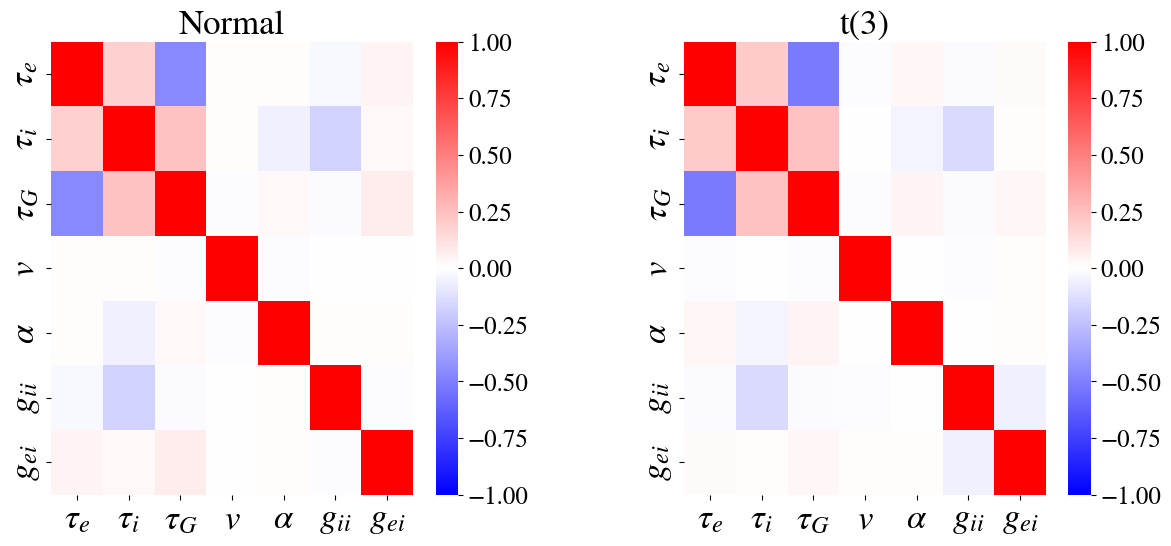

In [27]:
plt.figure(figsize=[14, 6], dpi=100)
plt.subplot(121)
plt.title(_paras.metd.norm, fontsize=25)
sns.heatmap(np.mean(part_corrs_mats_norm, axis=0), vmin=-1, vmax=1, cmap="bwr")
plt.xticks(np.arange(7)+0.5, _paras.name_order_latex, fontsize=25)
plt.yticks(np.arange(7)+0.5, _paras.name_order_latex, fontsize=25);
plt.subplot(122)
plt.title(_paras.metd.t3, fontsize=25)
sns.heatmap(np.mean(part_corrs_mats_t3, axis=0), vmin=-1, vmax=1, cmap="bwr")
plt.xticks(np.arange(7)+0.5, _paras.name_order_latex, fontsize=25)
plt.yticks(np.arange(7)+0.5, _paras.name_order_latex, fontsize=25);
plt.savefig(FIG_ROOT/f"neuroimage_r1/partial_corr_all_mean.jpg",  bbox_inches='tight', dpi=1000);

### Save for brain plots

In [326]:
anl_brain_vec = np.median([v/np.linalg.norm(v) for v in anl_sgmSPs], axis=0)

sbi_brain_vec = []
for ix in range(36):
    vec = result.post_sp_spss[sel_idx][ix].mean(axis=0)
    vec = vec/np.linalg.norm(vec)
    sbi_brain_vec.append(vec)
sbi_brain_vec =  np.median(sbi_brain_vec, axis=0)

meg_brain_vec = np.median([v/np.linalg.norm(v) for v in meg_sp_raws], axis=0)

np.savetxt(RES_ROOT/f"./newbds_sbi_sp_Brain_vec.txt", sbi_brain_vec) 
np.savetxt(RES_ROOT/f"./newbds_anl_sp_Brain_vec.txt", anl_brain_vec) 
np.savetxt(RES_ROOT/f"./newbds_meg_sp_Brain_vec.txt", meg_brain_vec) 